In [53]:
#import modules
from statsbombpy import sb

import pandas as pd
import matplotlib.pyplot as plt
import json

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier

import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
from bs4 import BeautifulSoup
import requests

In [3]:
competitions = sb.competitions()

In [4]:
help(sb.matches)

Help on function matches in module statsbombpy.sb:

matches(competition_id: int, season_id: int, fmt='dataframe', creds: dict = {'user': None, 'passwd': None})



In [5]:
# events = sb.competition_events(
#     country="England",
#     division= "Premier League",
#     season="2015/2016",
#     gender="male"
# )

In [6]:
#events.columns

In [7]:
competitions[
    (competitions['competition_name'].isin([
    'Premier League', '1. Bundesliga', 'La Liga', 'Ligue 1', 'Serie A']))
             & 
    (competitions['season_name']=='2015/2016')
            ]

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2023-12-12T07:43:33.436182,None,None,2023-12-12T07:43:33.436182
41,11,27,Spain,La Liga,male,False,False,2015/2016,2023-09-20T17:21:32.111535,2021-06-13T16:17:31.694,None,2023-09-20T17:21:32.111535
58,7,27,France,Ligue 1,male,False,False,2015/2016,2023-12-13T00:27:57.162379,None,None,2023-12-13T00:27:57.162379
62,2,27,England,Premier League,male,False,False,2015/2016,2023-11-14T11:25:33.476498,2021-06-13T16:17:31.694,None,2023-11-14T11:25:33.476498
64,12,27,Italy,Serie A,male,False,False,2015/2016,2023-12-13T17:32:46.423081,None,None,2023-12-13T17:32:46.423081


In [8]:
#competitions[competitions['competition_name']=='Champions League']

In [9]:
LaLiga = sb.matches(competition_id=11, season_id=27)
LaLiga.head()

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3825848,2015-09-23,20:00:00.000,Spain - La Liga,2015/2016,Levante UD,Eibar,2,2,available,...,None,5,Regular Season,Estadio Ciudad de Valencia,NaN,Luis Lucas Alcaraz González,José Luis Mendilibar Etxebarria,1.1.0,2,2
1,3825895,2015-09-23,22:00:00.000,Spain - La Liga,2015/2016,Las Palmas,Sevilla,2,0,available,...,None,5,Regular Season,Estadio de Gran Canaria,Carlos del Cerro Grande,Francisco Herrera Lorenzo,Unai Emery Etxegoien,1.1.0,2,2
2,3825894,2016-05-01,18:15:00.000,Spain - La Liga,2015/2016,RC Deportivo La Coruña,Getafe,0,2,available,...,None,36,Regular Season,Estadio Abanca-Riazor,Carlos Clos Gómez,Víctor Sánchez del Amo,Juan Eduardo Esnáider Belén,1.1.0,2,2
3,3825855,2016-05-02,20:30:00.000,Spain - La Liga,2015/2016,Málaga,Levante UD,3,1,available,...,None,36,Regular Season,Estadio La Rosaleda,Iñaki Bikandi Garrido,Javier Gracia Carlos,Joan Francesc Ferrer Sicilia,1.1.0,2,2
4,3825908,2016-05-15,19:00:00.000,Spain - La Liga,2015/2016,Espanyol,Eibar,4,2,available,...,None,38,Regular Season,RCDE Stadium,Mario Melero López,Constantin Gâlcă,José Luis Mendilibar Etxebarria,1.1.0,2,2


In [10]:
LaLiga.columns

Index(['match_id', 'match_date', 'kick_off', 'competition', 'season',
       'home_team', 'away_team', 'home_score', 'away_score', 'match_status',
       'match_status_360', 'last_updated', 'last_updated_360', 'match_week',
       'competition_stage', 'stadium', 'referee', 'home_managers',
       'away_managers', 'data_version', 'shot_fidelity_version',
       'xy_fidelity_version'],
      dtype='object')

In [11]:
print(pd.unique(LaLiga['home_team']))

['Levante UD' 'Las Palmas' 'RC Deportivo La Coruña' 'Málaga' 'Espanyol'
 'Sporting Gijón' 'Rayo Vallecano' 'Real Betis' 'Athletic Club'
 'Atlético Madrid' 'Valencia' 'Eibar' 'Getafe' 'Villarreal' 'Sevilla'
 'Granada' 'Real Sociedad' 'Celta Vigo' 'Real Madrid' 'Barcelona']


In [12]:
# elevations = {'Estadio Ciudad de Valencia' 'Estadio de Gran Canaria'
#  'Estadio Abanca-Riazor' 'Estadio La Rosaleda' 'RCDE Stadium'
#  'Estadio Municipal El Molinón' 'Estadio de Vallecas'
#  'Estadio Benito Villamarín' 'San Mamés Barria' 'Estadio Vicente Calderón'
#  'Estadio de Mestalla' 'Estadio Municipal de Ipurúa'
#  'Coliseum Alfonso Pérez' 'Estadio de la Cerámica'
#  'Estadio Ramón Sánchez Pizjuán' 'Estadio Nuevo Los Cármenes'
#  'Reale Arena' 'Abanca-Balaídos' 'Estadio Santiago Bernabéu'
#  'Spotify Camp Nou': 37}

In [13]:
LaLiga.iloc[0]

match_id                                         3825848
match_date                                    2015-09-23
kick_off                                    20:00:00.000
competition                              Spain - La Liga
season                                         2015/2016
home_team                                     Levante UD
away_team                                          Eibar
home_score                                             2
away_score                                             2
match_status                                   available
match_status_360                             unscheduled
last_updated                  2023-02-21T15:19:45.745471
last_updated_360                                    None
match_week                                             5
competition_stage                         Regular Season
stadium                       Estadio Ciudad de Valencia
referee                                              NaN
home_managers                Lu

In [14]:
example = sb.events(match_id=3754037)
example.columns

Index(['ball_receipt_outcome', 'ball_recovery_offensive',
       'ball_recovery_recovery_failure', 'carry_end_location',
       'clearance_aerial_won', 'clearance_body_part', 'clearance_head',
       'clearance_left_foot', 'clearance_right_foot', 'counterpress',
       'dribble_nutmeg', 'dribble_outcome', 'dribble_overrun', 'duel_outcome',
       'duel_type', 'duration', 'foul_committed_advantage',
       'foul_committed_card', 'foul_committed_offensive',
       'foul_committed_type', 'foul_won_advantage', 'foul_won_defensive',
       'goalkeeper_body_part', 'goalkeeper_end_location', 'goalkeeper_outcome',
       'goalkeeper_position', 'goalkeeper_technique', 'goalkeeper_type', 'id',
       'index', 'interception_outcome', 'location', 'match_id', 'minute',
       'miscontrol_aerial_won', 'off_camera', 'out', 'pass_aerial_won',
       'pass_angle', 'pass_assisted_shot_id', 'pass_body_part', 'pass_cross',
       'pass_cut_back', 'pass_end_location', 'pass_goal_assist', 'pass_height',
   

In [15]:
relevant_attributes = ['minute', 'second', 'team', 'shot_statsbomb_xg',
                       'player', 'position', 'location', 'shot_body_part',
       'shot_end_location', 'shot_first_time', 
         'shot_technique',
       'shot_type', 'type','shot_outcome']

In [16]:
# check_attributes = ['pass_angle', 'pass_assisted_shot_id', 'pass_body_part', 'pass_cross',
#        'pass_cut_back', 'pass_end_location', 'pass_goal_assist', 'pass_height',
#        'pass_inswinging', 'pass_length', 'pass_no_touch', 'pass_outcome',
#        'pass_outswinging', 'pass_recipient', 'pass_recipient_id',
#        'pass_shot_assist', 'pass_straight', 'pass_switch', 'pass_technique',
#        'pass_type', 'type', 'shot_outcome', 'location']
# first_match_df = pd.DataFrame(columns=check_attributes)
# for match in PremierLeague['match_id'][:1]:
#     match_df = sb.events(match_id=match)
#     relevant_match_df = match_df[relevant_attributes][match_df['type']=='Shot']
#     first_match_df = pd.concat([first_match_df, relevant_match_df], ignore_index=True)

# first_match_df['shot_outcome'] = first_match_df['shot_outcome'].replace(to_replace={'Off T': 0, 'Blocked': 0, 'Saved': 0, 'Goal': 1, 'Wayward': 0, 'Post': 0,
#                'Saved to Post': 0, 'Saved Off Target': 0})

# first_match_df['distance'] = first_match_df.apply(lambda row: np.sqrt(np.abs(row.location[0]-120)**2 + 
#                                                      np.abs(row.location[1]-40)**2), axis=1)
# first_match_df

In [17]:
LaLiga_shots_df = pd.DataFrame(columns=relevant_attributes)

In [18]:
start = time.time()
for match in LaLiga['match_id']:#[:10]:
    match_df = sb.events(match_id=match)
    relevant_match_df = match_df[relevant_attributes][match_df['type']=='Shot']
    LaLiga_shots_df = pd.concat([LaLiga_shots_df, relevant_match_df], ignore_index=True)

LaLiga_shots_df['shot_outcome'] = LaLiga_shots_df['shot_outcome'].replace(
    to_replace={'Off T': 0, 'Blocked': 0, 'Saved': 0, 'Goal': 1, 'Wayward': 0, 'Post': 0,
               'Saved to Post': 0, 'Saved Off Target': 0})

LaLiga_shots_df['distance'] = LaLiga_shots_df.apply(lambda row: np.sqrt(np.abs(
    row.location[0]-120)**2 + np.abs(row.location[1]-40)**2), axis=1)
LaLiga_shots_df['shot_angle'] = LaLiga_shots_df.apply(
    lambda row: np.arctan2(np.abs(40-row.location[1]), np.abs(120-row.location[0])), axis=1)
end = time.time()
print(f'script run time: {(end - start)/60} minutes')
LaLiga_shots_df

script run time: 5.251278948783875 minutes


,minute,second,team,shot_statsbomb_xg,player,position,location,shot_body_part,shot_end_location,shot_first_time,shot_technique,shot_type,type,shot_outcome,distance,shot_angle
0,2,58,Levante UD,0.100429,Jefferson Andrés Lerma Solís,Left Center Midfield,"[112.5, 42.1]",Head,"[120.0, 41.5, 5.9]",NaN,Normal,Open Play,Shot,0,7.788453,0.273009
1,8,33,Eibar,0.023138,Sergio Gontán Gallardo,Right Wing,"[90.9, 39.9]",Right Foot,"[119.1, 42.5, 0.8]",NaN,Normal,Open Play,Shot,0,29.100172,0.003436
2,9,26,Eibar,0.034535,Adrián González Morales,Center Attacking Midfield,"[103.1, 52.5]",Right Foot,"[104.5, 51.8]",True,Half Volley,Open Play,Shot,0,21.020466,0.636841
3,9,49,Eibar,0.394774,Borja González Tomás,Center Forward,"[116.6, 38.6]",Head,"[120.0, 37.0, 1.2]",NaN,Normal,Open Play,Shot,1,3.676955,0.390607
4,15,40,Levante UD,0.077194,Nabil Ghilas,Right Center Forward,"[112.4, 35.8]",Head,"[120.0, 34.8, 6.6]",NaN,Normal,Open Play,Shot,0,8.683317,0.504861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9163,74,16,Barcelona,0.123344,Ivan Rakitić,Right Center Midfield,"[105.8, 40.0]",Left Foot,"[116.3, 38.3, 0.6]",NaN,Normal,Open Play,Shot,0,14.200000,0.000000
9164,83,37,Barcelona,0.070986,Neymar da Silva Santos Junior,Left Wing,"[110.3, 34.4]",Right Foot,"[114.3, 35.8]",NaN,Half Volley,Open Play,Shot,0,11.200446,0.523576
9165,84,19,Barcelona,0.075232,Gerard Piqué Bernabéu,Right Center Back,"[106.2, 40.1]",Right Foot,"[108.6, 40.3]",NaN,Normal,Open Play,Shot,0,13.800362,0.007246
9166,86,21,Valencia,0.299719,Francisco Alcácer García,Center Forward,"[111.1, 41.7]",Right Foot,"[119.0, 33.0]",True,Normal,Open Play,Shot,0,9.060905,0.188738


## Describing the Data

In [19]:
LaLiga_shots_df.describe()

,shot_statsbomb_xg,shot_outcome,distance,shot_angle
count,9168.000000,9168.000000,9168.000000,9168.000000
mean,0.106869,0.110602,19.046284,0.493892
std,0.148027,0.313656,8.685988,0.327645
min,0.000180,0.000000,0.632456,0.000000
25%,0.027914,0.000000,12.000417,0.212683
50%,0.053508,0.000000,18.261709,0.463648
75%,0.112384,0.000000,25.269300,0.727580
max,0.980070,1.000000,74.867416,1.570796


In [22]:
LaLiga_shots_df = LaLiga_shots_df[LaLiga_shots_df.shot_type != 'Corner']

In [23]:
LaLiga_shots_df['shot_outcome'].value_counts()

shot_outcome
0    8153
1    1014
Name: count, dtype: int64

In [83]:
LaLiga_shots_df['team'].value_counts()['Real Madrid']

717

In [95]:
LaLiga_team_summary_df = pd.DataFrame(columns = ['team', 'shots', 'goals', 'statsbomb_xg'])
for team in pd.unique(LaLiga_shots_df['team']):
    shot_sum = LaLiga_shots_df['team'].value_counts()[team]
    goal_sum = sum(LaLiga_shots_df[LaLiga_shots_df['team']==team]['shot_outcome'])
    statsbomb_xg_sum = sum(LaLiga_shots_df[LaLiga_shots_df['team']==team]['shot_statsbomb_xg'])
    new_row = pd.Series({'team': team, 'shots': shot_sum, 'goals': goal_sum, 'statsbomb_xg': statsbomb_xg_sum})
    #LaLiga_team_summary_df = pd.concat([LaLiga_team_summary_df,new_row], ignore_index=False)
    LaLiga_team_summary_df.loc[len(LaLiga_team_summary_df)]=new_row
LaLiga_team_summary_df = LaLiga_team_summary_df.sort_values(by=['shots'], ascending=False)
LaLiga_team_summary_df

,team,shots,goals,statsbomb_xg
12,Real Madrid,717,108,80.794913
19,Barcelona,604,109,91.433618
10,Rayo Vallecano,501,52,50.392516
14,Atlético Madrid,483,62,52.972623
3,Sevilla,472,50,60.888533
17,Real Sociedad,466,44,46.092116
13,Athletic Club,465,57,50.270193
4,RC Deportivo La Coruña,457,41,41.41664
6,Málaga,456,37,43.180615
15,Celta Vigo,446,51,50.179205


In [25]:
LaLiga_shots_df.columns

Index(['minute', 'second', 'team', 'shot_statsbomb_xg', 'player', 'position',
       'location', 'shot_body_part', 'shot_end_location', 'shot_first_time',
       'shot_technique', 'shot_type', 'type', 'shot_outcome', 'distance',
       'shot_angle'],
      dtype='object')

## Training Model

In [26]:
cap_x_df, y_df = pd.concat([LaLiga_shots_df.iloc[:,:-3], LaLiga_shots_df.iloc[:,-2:]], axis=1),LaLiga_shots_df.iloc[:,-3].to_frame()

In [27]:
train_cap_x_df, test_cap_x_df, train_y_df, test_y_df = \
train_test_split(cap_x_df, y_df,
                 test_size=0.20,
                random_state=42,
                 shuffle=True,
                stratify=y_df)

In [28]:
target_attr = 'shot_outcome'

In [29]:
numerical_attrs = ['distance', 'minute', 'shot_angle']

In [30]:
nominal_attrs = ['shot_technique', 'shot_type', 'shot_body_part', 'position', 'shot_first_time', 'position']

In [31]:
numerical_transformer = Pipeline(
        steps=[("imputer", SimpleImputer()),
               ("scaler", StandardScaler())]
    )

In [32]:
nominal_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="most_frequent")),
               #('target_encoder', TargetEncoder(target_type=target_type, random_state=42)),
               ("target_encoder", OrdinalEncoder()),
               ("scaler", StandardScaler())
               ]
    )

In [33]:
preprocessor = ColumnTransformer(
        transformers=[
            ('numerical', numerical_transformer, numerical_attrs),
            ('nominal', nominal_transformer, nominal_attrs)
        ]
    )

## Try with Logistic Regression

In [34]:
estimator = LogisticRegression()

In [35]:
composite_estimator = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', estimator)])

In [36]:
composite_estimator.fit(train_cap_x_df, train_y_df.values.ravel())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['distance', 'minute',
                                                   'shot_angle']),
                                                 ('nominal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('target_encoder',
                                                                   OrdinalEncoder()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['shot_technique',
                                                   'shot_type',
                                                   'shot_body_part', 'position',
                                                   'shot_first_time',
                                                   'position'])])),
                ('estimator', LogisticRegression())])

In [37]:
composite_estimator.predict_proba(train_cap_x_df)

array([[0.99436218, 0.00563782],
       [0.84869052, 0.15130948],
       [0.98298823, 0.01701177],
       ...,
       [0.86698343, 0.13301657],
       [0.70870726, 0.29129274],
       [0.96762148, 0.03237852]])

In [38]:
print("Training set actual goal information")
print(train_y_df[target_attr].value_counts())
print("Training set naive model total xG",sum(composite_estimator.predict_proba(train_cap_x_df)[:,1]))
print("Training set Statsbomb total xG:", sum(train_cap_x_df['shot_statsbomb_xg']))

Training set actual goal information
shot_outcome
0    6522
1     811
Name: count, dtype: int64
Training set naive model total xG 810.9985734235582
Training set Statsbomb total xG: 778.340562411


In [39]:
def plot_comparison(model1, model1_name, model2, model2_name, outcome):
    plt.scatter(model1, model2,c=outcome)
    plt.xlabel(model1_name)
    plt.ylabel(model2_name)
    plt.xlim(0,1.1)
    plt.ylim(0,1.1)
    #.legend(label=outcome
    z = np.polyfit(model1, model2,1)
    p = np.poly1d(z)
    plt.plot(model1, p(model1),"r--")
    print("y=%.2fx+%.2f"%(z[0],z[1]))
    print("$R^2$=", r2_score(model1,model2))

In [40]:
pd.unique(LaLiga_shots_df['shot_type'])

array(['Open Play', 'Free Kick', 'Penalty'], dtype=object)

In [41]:
test_predictions = composite_estimator.predict_proba(test_cap_x_df)

In [42]:
print("Test set actual goal information")
print(test_y_df[target_attr].value_counts())
print("Test set naive model total xG", sum(test_predictions[:,1]))
print("Statsbomb total xG:", sum(test_cap_x_df['shot_statsbomb_xg']))

Test set actual goal information
shot_outcome
0    1631
1     203
Name: count, dtype: int64
Test set naive model total xG 210.04441355421503
Statsbomb total xG: 201.43405838410033


In [43]:
print(test_y_df[target_attr].value_counts())

shot_outcome
0    1631
1     203
Name: count, dtype: int64


In [44]:
print("Statsbomb total xG:", sum(test_cap_x_df['shot_statsbomb_xg']))

Statsbomb total xG: 201.43405838410033


In [45]:
SBModel = test_cap_x_df['shot_statsbomb_xg']
proposed_model = test_predictions[:,1]
shot_outcome = test_y_df[target_attr]

y=1.02x+-0.01
$R^2$= 0.19634341764536856


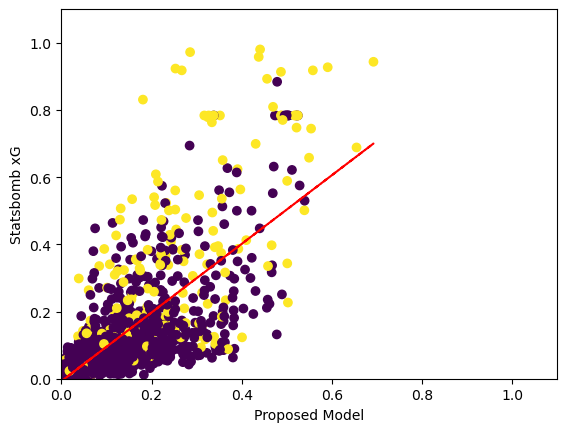

In [46]:
plot_comparison(proposed_model, "Proposed Model", SBModel, 'Statsbomb xG', shot_outcome)

## Try with SGDClassifier

In [55]:
#estimator = SGDClassifier()
estimator = SGDClassifier(
        loss='log_loss', 
        penalty='l2', 
        alpha=0.0001, 
        l1_ratio=0.15, 
        fit_intercept=True, 
        max_iter=1000, 
        tol=0.001, 
        shuffle=True, 
        verbose=0, 
        epsilon=0.1, 
        n_jobs=None, 
        random_state=42, 
        learning_rate='optimal', 
        eta0=0.0, 
        power_t=0.5, 
        early_stopping=False, 
        validation_fraction=0.1, 
        n_iter_no_change=5, 
        class_weight=None, 
        warm_start=False, 
        average=False
    )

In [56]:
composite_estimator = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', estimator)])

In [57]:
composite_estimator.fit(train_cap_x_df, train_y_df.values.ravel())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['distance', 'minute',
                                                   'shot_angle']),
                                                 ('nominal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('target_encoder',
                                                                   OrdinalEncoder()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['shot_technique',
                                                   'shot_type',
                                                   'shot_body_part', 'position',
                                                   'shot_first_time',
                                                   'position'])])),
                ('estimator', SGDClassifier(loss='log_loss', random_state=42))])

In [58]:
composite_estimator.predict_proba(train_cap_x_df)

array([[0.99839525, 0.00160475],
       [0.92004275, 0.07995725],
       [0.98359009, 0.01640991],
       ...,
       [0.89240755, 0.10759245],
       [0.68588751, 0.31411249],
       [0.98778999, 0.01221001]])

In [59]:
print("Training set actual goal information")
print(train_y_df[target_attr].value_counts())
print("Training set naive model total xG",sum(composite_estimator.predict_proba(train_cap_x_df)[:,1]))
print("Training set Statsbomb total xG:", sum(train_cap_x_df['shot_statsbomb_xg']))

Training set actual goal information
shot_outcome
0    6522
1     811
Name: count, dtype: int64
Training set naive model total xG 792.3954782238878
Training set Statsbomb total xG: 778.340562411


In [60]:
def plot_comparison(model1, model1_name, model2, model2_name, outcome):
    plt.scatter(model1, model2,c=outcome)
    plt.xlabel(model1_name)
    plt.ylabel(model2_name)
    plt.xlim(0,1.1)
    plt.ylim(0,1.1)
    #.legend(label=outcome
    z = np.polyfit(model1, model2,1)
    p = np.poly1d(z)
    plt.plot(model1, p(model1),"r--")
    print("y=%.2fx+%.2f"%(z[0],z[1]))
    print("$R^2$=", r2_score(model1,model2))

In [61]:
pd.unique(LaLiga_shots_df['shot_type'])

array(['Open Play', 'Free Kick', 'Penalty'], dtype=object)

In [62]:
test_predictions = composite_estimator.predict_proba(test_cap_x_df)

In [63]:
print("Test set actual goal information")
print(test_y_df[target_attr].value_counts())
print("Test set naive model total xG", sum(test_predictions[:,1]))
print("Statsbomb total xG:", sum(test_cap_x_df['shot_statsbomb_xg']))

Test set actual goal information
shot_outcome
0    1631
1     203
Name: count, dtype: int64
Test set naive model total xG 203.17603679061799
Statsbomb total xG: 201.43405838410033


In [64]:
print(test_y_df[target_attr].value_counts())

shot_outcome
0    1631
1     203
Name: count, dtype: int64


In [65]:
print("Statsbomb total xG:", sum(test_cap_x_df['shot_statsbomb_xg']))

Statsbomb total xG: 201.43405838410033


In [66]:
SBModel = test_cap_x_df['shot_statsbomb_xg']
proposed_model = test_predictions[:,1]
shot_outcome = test_y_df[target_attr]

y=0.78x+0.02
$R^2$= 0.1548967061310238


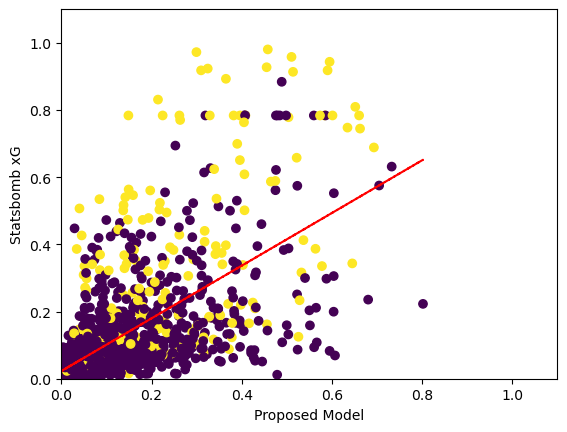

In [67]:
plot_comparison(proposed_model, "Proposed Model", SBModel, 'Statsbomb xG', shot_outcome)

## Try with RandomForestClassifier

In [68]:
estimator = RandomForestClassifier(
    n_estimators=500, 
    criterion='gini', 
    max_depth=None, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_features='sqrt', 
    max_leaf_nodes=16, 
    min_impurity_decrease=0.0, 
    bootstrap=True, 
    oob_score=False, 
    n_jobs=-1, 
    random_state=42,
    verbose=0, 
    warm_start=False, 
    class_weight=None, 
    ccp_alpha=0.0, 
    max_samples=None
)

In [69]:
composite_estimator = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', estimator)])

In [70]:
composite_estimator.fit(train_cap_x_df, train_y_df.values.ravel())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['distance', 'minute',
                                                   'shot_angle']),
                                                 ('nominal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('target_encoder',
                                                                   OrdinalEncoder()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['shot_technique',
                                                   'shot_type',
                                                   'shot_body_part', 'position',
                                                   'shot_first_time',
                                                   'position'])])),
                ('estimator',
                 RandomForestClassifier(max_leaf_nodes=16, n_estimators=500,
                                        n_jobs=-1, random_state=42))])

In [71]:
composite_estimator.predict_proba(train_cap_x_df)

array([[0.94872996, 0.05127004],
       [0.83006043, 0.16993957],
       [0.95128807, 0.04871193],
       ...,
       [0.86849477, 0.13150523],
       [0.81667531, 0.18332469],
       [0.94896455, 0.05103545]])

In [72]:
print("Training set actual goal information")
print(train_y_df[target_attr].value_counts())
print("Training set naive model total xG",sum(composite_estimator.predict_proba(train_cap_x_df)[:,1]))
print("Training set Statsbomb total xG:", sum(train_cap_x_df['shot_statsbomb_xg']))

Training set actual goal information
shot_outcome
0    6522
1     811
Name: count, dtype: int64
Training set naive model total xG 809.7278868133851
Training set Statsbomb total xG: 778.340562411


In [73]:
def plot_comparison(model1, model1_name, model2, model2_name, outcome):
    plt.scatter(model1, model2,c=outcome)
    plt.xlabel(model1_name)
    plt.ylabel(model2_name)
    plt.xlim(0,1.1)
    plt.ylim(0,1.1)
    #.legend(label=outcome
    z = np.polyfit(model1, model2,1)
    p = np.poly1d(z)
    plt.plot(model1, p(model1),"r--")
    print("y=%.2fx+%.2f"%(z[0],z[1]))
    print("$R^2$=", r2_score(model1,model2))

In [74]:
pd.unique(LaLiga_shots_df['shot_type'])

array(['Open Play', 'Free Kick', 'Penalty'], dtype=object)

In [75]:
test_predictions = composite_estimator.predict_proba(test_cap_x_df)

In [76]:
print("Test set actual goal information")
print(test_y_df[target_attr].value_counts())
print("Test set naive model total xG", sum(test_predictions[:,1]))
print("Statsbomb total xG:", sum(test_cap_x_df['shot_statsbomb_xg']))

Test set actual goal information
shot_outcome
0    1631
1     203
Name: count, dtype: int64
Test set naive model total xG 205.46646451502517
Statsbomb total xG: 201.43405838410033


In [77]:
print(test_y_df[target_attr].value_counts())

shot_outcome
0    1631
1     203
Name: count, dtype: int64


In [78]:
print("Statsbomb total xG:", sum(test_cap_x_df['shot_statsbomb_xg']))

Statsbomb total xG: 201.43405838410033


In [79]:
SBModel = test_cap_x_df['shot_statsbomb_xg']
proposed_model = test_predictions[:,1]
shot_outcome = test_y_df[target_attr]

y=1.23x+-0.03
$R^2$= 0.1353772184151727


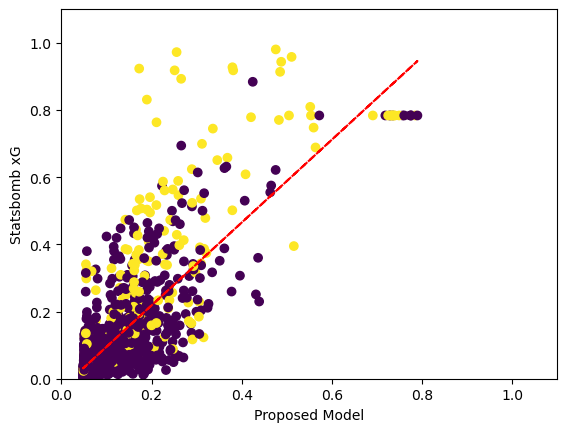

In [80]:
plot_comparison(proposed_model, "Proposed Model", SBModel, 'Statsbomb xG', shot_outcome)